In [1]:
import torch
from torch import nn

In [2]:
class LinearFunction(torch.autograd.Function):

    # Note that both forward and backward are @staticmethods
    @staticmethod
    # bias is an optional argument
    def forward(ctx, input, weight, bias=None):
        ctx.save_for_backward(input, weight, bias)
        output = input.mm(weight.t())
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        # This is a pattern that is very convenient - at the top of backward
        # unpack saved_tensors and initialize all gradients w.r.t. inputs to
        # None. Thanks to the fact that additional trailing Nones are
        # ignored, the return statement is simple even when the function has
        # optional inputs.
        print('In backward.')
        input, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None

        # These needs_input_grad checks are optional and there only to
        # improve efficiency. If you want to make your code simpler, you can
        # skip them. Returning gradients for inputs that don't require it is
        # not an error.
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight, grad_bias


In [3]:
class Linear(torch.nn.Module):
    def __init__(self, input_features, output_features, bias=True):
        super(Linear, self).__init__()
        self.input_features = input_features
        self.output_features = output_features

        # nn.Parameter is a special kind of Tensor, that will get
        # automatically registered as Module's parameter once it's assigned
        # as an attribute. Parameters and buffers need to be registered, or
        # they won't appear in .parameters() (doesn't apply to buffers), and
        # won't be converted when e.g. .cuda() is called. You can use
        # .register_buffer() to register buffers.
        # nn.Parameters require gradients by default.
        self.weight = nn.Parameter(torch.Tensor(output_features, input_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(output_features))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)

        # Not a very smart way to initialize weights
        self.weight.data.uniform_(-0.1, 0.1)
        if bias is not None:
            self.bias.data.uniform_(-0.1, 0.1)

    def forward(self, input):
        # See the autograd section for explanation of what happens here.
        return LinearFunction.apply(input, self.weight, self.bias)

    def extra_repr(self):
        # (Optional)Set the extra information about this module. You can test
        # it by printing an object of this class.
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

In [4]:
fc = Linear(3,64)

In [5]:
tensor = torch.randn([100,3])

In [6]:
output = fc(tensor)

In [51]:
output.shape

torch.Size([100, 64])

In [52]:
torch.autograd.backward(output, torch.randn([100,64]))

In backward.


In [9]:
torch.autograd.grad(output,tensor)

RuntimeError: grad can be implicitly created only for scalar outputs

In [8]:
(2*64)*(2*8)*4

8192

In [7]:
import torchviz

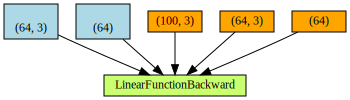

In [8]:
torchviz.make_dot(output)